In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,average_precision_score,fbeta_score,roc_curve,auc,classification_report
from sklearn.ensemble import VotingClassifier

In [2]:
train=pd.read_csv('titanic_train.csv')
test=pd.read_csv('titanic_test.csv')
print('Shape of Training Set:\n',train.shape)
print('Shape of Test Set:\n',test.shape)

Shape of Training Set:
 (891, 12)
Shape of Test Set:
 (418, 11)


## EDA & FEATURE ENGINEERING

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
def missing_data(data):
    total=data.isnull().count().sort_values(ascending=False)
    percentage=(100*data.isnull().sum()/data.isnull().count())
    ms=pd.DataFrame({'Total':data.isnull().sum(),'Percentage':percentage}).sort_values(by='Percentage',ascending=False)
    ms=ms[ms['Percentage']>0]
    ms['Percentage'].plot.bar().set_title('Percentage missing value')
    return ms

,Total,Percentage
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


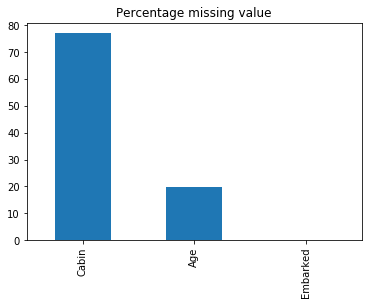

In [6]:
missing_data(train)#missing value for various feature in training set

,Total,Percentage
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


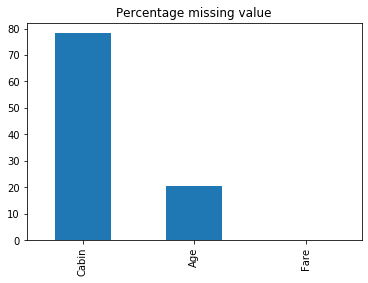

In [7]:
missing_data(test)#missing value for various feature in test set

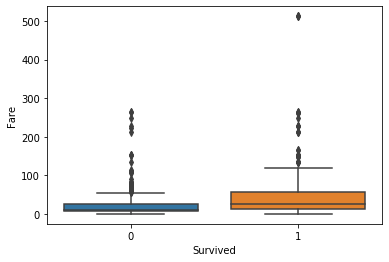

In [8]:
sns.boxplot(x='Survived',y='Fare',data=train)#fare was higher for survived passenger

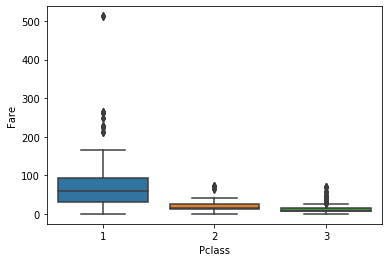

In [9]:
sns.boxplot(x='Pclass',y='Fare',data=train)

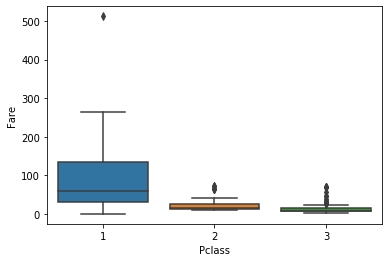

In [10]:
sns.boxplot(x='Pclass',y='Fare',data=test)#for both train and test set, fare is decreasing with Pclass so fare is ordinal variable

In [11]:
avg_fare=test.groupby(by='Pclass').mean()['Fare']
def fill_fare(pclass,fare):
    if np.isnan(fare):
        return avg_fare[pclass]
    else:
        return fare
test['Fare']=test.apply(lambda x:fill_fare(x['Pclass'],x['Fare']),axis=1 )#filling missing value of test set for feature FARE

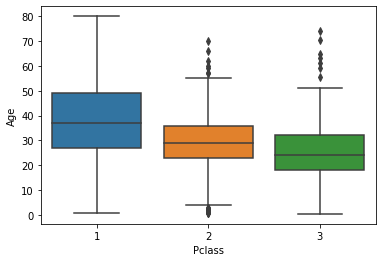

In [12]:
sns.boxplot(x='Pclass',y='Age',data=train)

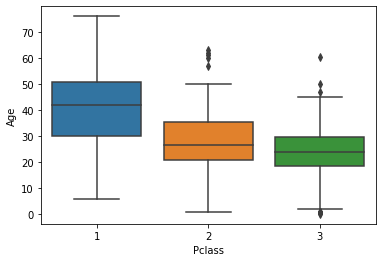

In [13]:
sns.boxplot(x='Pclass',y='Age',data=test)#for both train and test set Age is decreasing with Pclass, so we will fill missing 
#value for age with median value of corresponding Pclass

In [14]:
median_age=train.groupby('Pclass').median()['Age']
def fill_age(pclass,age):
    if np.isnan(age):
        return median_age[pclass]
    else:
        return age
train['Age']=train.apply(lambda x:fill_age(x['Pclass'],x['Age']),axis=1 )
test['Age']=test.apply(lambda x:fill_age(x['Pclass'],x['Age']),axis=1 )

In [15]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [16]:
#combining Parch and SibSp into single feature
train['family_size']=train['Parch']+train['SibSp']+1
test['family_size']=test['Parch']+test['SibSp']+1

In [17]:
data=[train,test]
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""
for dataset in data:
    dataset['Title'] = dataset['Name'].apply(get_title)
for dataset in data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

      Pclass
1  62.962963
2  47.282609
3  24.236253


Text(0.5, 1.0, 'Percentage Survived in various Passenger Class')

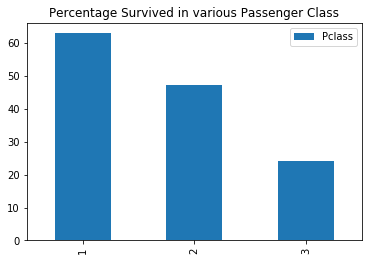

In [18]:
train_survived=train[train['Survived']==1]
df=pd.DataFrame(100*train_survived['Pclass'].value_counts()/train['Pclass'].value_counts())
print(df)
df.plot.bar().set_title('Percentage Survived in various Passenger Class')#from the below bar plot clearly Pclass has significant effect on Survived feature

              Sex
female  74.203822
male    18.890815


Text(0.5, 1.0, 'Percentage Survived for Male/Female')

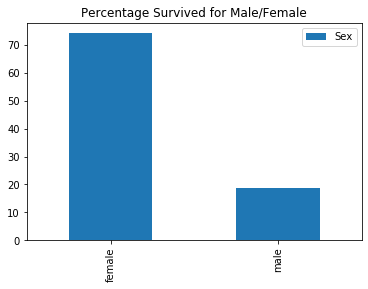

In [19]:
train_survived=train[train['Survived']==1]
df=pd.DataFrame(100*train_survived['Sex'].value_counts()/train['Sex'].value_counts())
print(df)
df.plot.bar().set_title('Percentage Survived for Male/Female')#from the below bar plot clearly Sex Feature has significant effect on Survived feature

    Embarked
S  33.695652
C  55.357143
Q  38.961039


Text(0.5, 1.0, 'Percentage Survived for various Embarked category')

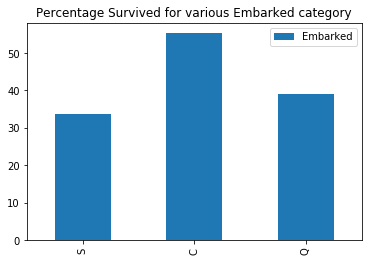

In [20]:
train_survived=train[train['Survived']==1]
df=pd.DataFrame(100*train_survived['Embarked'].value_counts()/train['Embarked'].value_counts())
print(df)
df.plot.bar().set_title('Percentage Survived for various Embarked category')#from the below bar plot clearly Embarked has significant effect on Survived feature

In [21]:
#converting continious age and fare to categorical variable
train['Fare_bin'] = pd.cut(train['Fare'],bins=[-1,7.91,14.45,31,514],labels=['Low_fare','median_fare','Average_fare','high_fare'])
train['Age_bin'] = pd.cut(train['Age'], bins=[0,12,20,40,120],labels=['Children','Teenage','Adult','Elder'])
test['Fare_bin'] = pd.cut(test['Fare'],bins=[-1,7.91,14.45,31,514],labels=['Low_fare','median_fare','Average_fare','high_fare'])
test['Age_bin'] = pd.cut(test['Age'], bins=[0,12,20,40,120],labels=['Children','Teenage','Adult','Elder'])

In [22]:
#passengerID has no significamt impact on survival analysis so we can drop them
# Cabin has both more than 75 percent missing value in both training and testing set so filling missing value is not so logical,
#we should drop Cabin feature
#Title feature has been extracted from name feature , so we can drop Name feature
# family_size feature  has been created using SibSp(Sibling/Spouse) and Parch(Parents/Child ) feature , so we can drop Parch 
#and SibSp feature
#Pclass is a ordinal variable so no need to convert it to a categorical feature , we will keep it as a numerical feature
# at this time point,Didn't get any useful information from ticket feature so I will drop ticket feature.

In [23]:
passenger_id=test['PassengerId']
drop_columns=['PassengerId','Name','SibSp','Parch','Ticket','Cabin']
for i in data:
    i.drop(drop_columns,axis=1,inplace=True)

In [24]:
get_dummies=pd.get_dummies(train[['Sex','Embarked','Title','Fare_bin','Age_bin']],drop_first=True)
train=pd.concat([train,get_dummies],axis=1)
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'family_size',
       'Title', 'Fare_bin', 'Age_bin', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
       'Fare_bin_median_fare', 'Fare_bin_Average_fare', 'Fare_bin_high_fare',
       'Age_bin_Teenage', 'Age_bin_Adult', 'Age_bin_Elder'],
      dtype='object')

In [25]:
drop_columns=['Sex','Embarked','Title','Fare_bin','Age_bin']
train.drop(drop_columns,axis=1,inplace=True)

In [26]:
get_dummies=pd.get_dummies(test[['Sex','Embarked','Title','Fare_bin','Age_bin']],drop_first=True)
test=pd.concat([test,get_dummies],axis=1)
test.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'family_size', 'Title',
       'Fare_bin', 'Age_bin', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
       'Fare_bin_median_fare', 'Fare_bin_Average_fare', 'Fare_bin_high_fare',
       'Age_bin_Teenage', 'Age_bin_Adult', 'Age_bin_Elder'],
      dtype='object')

In [27]:
drop_columns=['Sex','Embarked','Title','Fare_bin','Age_bin']
test.drop(drop_columns,axis=1,inplace=True)

In [28]:
x_train=train.drop('Survived',axis=1)
y_train=train['Survived']

## Decision Tree, Random Forest and XGB Classifier with Grid Search 

In [29]:
#Initialize the classifier
clf = DecisionTreeClassifier(random_state=42)

#parameters for tuning
parameters = {
              'max_features': [None, 'sqrt', 'log2'],
              'max_depth':[5,8,15,None],
              'min_samples_split':[5,10,20],
              }
# grid search using roc_auc score
gs1=GridSearchCV(clf,param_grid=parameters,cv=5,scoring="roc_auc")
grid_fit=gs1.fit(x_train,y_train)

# obtain the estimator
best_clf = grid_fit.best_estimator_

# find the best parameter
gs1.best_params_

{'max_depth': 5, 'max_features': None, 'min_samples_split': 20}

Unoptimized model
------
AUPRC on train data: 0.9726
AUROC on train data: 0.9806
F-score on train data: 0.9660

Optimized Model
------
Final AUPRC on the train data: 0.7110
Final AUROC the train data: 0.8280
Final F-score on the train data: 0.7705
[[487  62]
 [ 79 263]]
Area Under ROC Curve for train data:  0.906922740975085


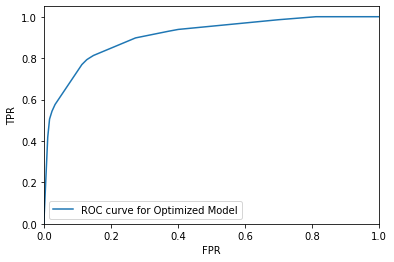

In [30]:
#fitting the classifier with best parameters obtained
r1=DecisionTreeClassifier(max_depth=5, max_features=None, min_samples_split=20,random_state=42).fit(x_train,y_train)

#predictions using the unoptimized model and optimized model
predictions = (clf.fit(x_train, y_train)).predict(x_train)
best_predictions = best_clf.predict(x_train)

# score before optimization 
print ("Unoptimized model\n------")
print ("AUPRC on train data: {:.4f}".format(average_precision_score(y_train, predictions)))
print ("AUROC on train data: {:.4f}".format(roc_auc_score(y_train, predictions)))
print ("F-score on train data: {:.4f}".format(fbeta_score(y_train, predictions, beta = 5)))

#score after optimization
print ("\nOptimized Model\n------")
print ("Final AUPRC on the train data: {:.4f}".format(average_precision_score(y_train, best_predictions)))
print ("Final AUROC the train data: {:.4f}".format(roc_auc_score(y_train, best_predictions)))
print ("Final F-score on the train data: {:.4f}".format(fbeta_score(y_train, best_predictions, beta = 5)))
print(confusion_matrix(y_train,best_predictions))

probas_ = best_clf.predict_proba(x_train)
fpr, tpr, thresholds = roc_curve(y_train, probas_[:, 1])
area = auc(fpr, tpr)
print("Area Under ROC Curve for train data: ",area)
#plot roc curve
plt.plot(fpr, tpr, label='ROC curve for Optimized Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.show()

In [31]:
#Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# parameters to tune

parameters = {
              'max_features': [0.5,0.75],
              'max_depth':[8,12,15],
              "n_estimators":[100,200,300,400]
              }

# grid search using roc_auc score
gs2 = GridSearchCV(clf, parameters, scoring="roc_auc")

# find the best parameter
grid_fit = gs2.fit(x_train, y_train)

# obtain the estimator
best_clf = grid_fit.best_estimator_

# find the best parameter
gs2.best_params_

{'max_depth': 8, 'max_features': 0.75, 'n_estimators': 100}

Unoptimized model
------
AUPRC on train data: 0.9694
AUROC on train data: 0.9823
F-score on train data: 0.9741

Optimized Model
------
Final AUPRC on the train data: 0.8603
Final AUROC the train data: 0.9105
Final F-score on the train data: 0.8569
[[531  18]
 [ 50 292]]
Area Under ROC Curve for train data:  0.9784270177568999


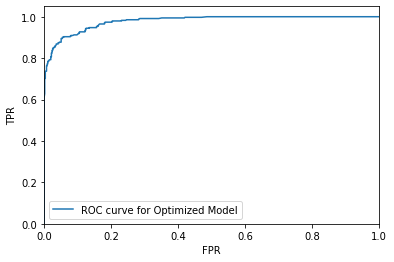

In [32]:
#fitting the classifier with best parameters obtained
r2=RandomForestClassifier(max_depth=8, max_features=.75, n_estimators=100,random_state=42).fit(x_train,y_train)

#predictions using the unoptimized model and optimized model
predictions = (clf.fit(x_train, y_train)).predict(x_train)
best_predictions = best_clf.predict(x_train)
# score before optimization 
print ("Unoptimized model\n------")
print ("AUPRC on train data: {:.4f}".format(average_precision_score(y_train, predictions)))
print ("AUROC on train data: {:.4f}".format(roc_auc_score(y_train, predictions)))
print ("F-score on train data: {:.4f}".format(fbeta_score(y_train, predictions, beta = 5)))

#score after optimization
print ("\nOptimized Model\n------")
print ("Final AUPRC on the train data: {:.4f}".format(average_precision_score(y_train, best_predictions)))
print ("Final AUROC the train data: {:.4f}".format(roc_auc_score(y_train, best_predictions)))
print ("Final F-score on the train data: {:.4f}".format(fbeta_score(y_train, best_predictions, beta = 5)))
print(confusion_matrix(y_train,best_predictions))

probas_ = best_clf.predict_proba(x_train)
fpr, tpr, thresholds = roc_curve(y_train, probas_[:, 1])
area = auc(fpr, tpr)
print("Area Under ROC Curve for train data: ",area)
#plot roc curve
plt.plot(fpr, tpr, label='ROC curve for Optimized Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.show()


In [33]:
#Initialize the classifier
clf = xgb.XGBClassifier(colsample_bytree=0.5,colsample_bylevel=0.5)

# parameters to tune

parameters = {
              "n_estimators":[100,200,300,400],
              "learning_rate":[0.01,0.05,0.1,0.2],
              "max_depth":[2,4,6]
              }

# grid search using roc_auc score
gs3 = GridSearchCV(clf, parameters, scoring="roc_auc")

# find the best parameter
grid_fit = gs3.fit(x_train, y_train)

# obtain the estimator
best_clf = grid_fit.best_estimator_

# find the best parameter
gs3.best_params_

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 400}

Unoptimized model
------
AUPRC on train data: 0.9005
AUROC on train data: 0.9396
F-score on train data: 0.9082

Optimized Model
------
Final AUPRC on the train data: 0.8079
Final AUROC the train data: 0.8800
Final F-score on the train data: 0.8161
[[520  29]
 [ 64 278]]
Area Under ROC Curve for train data:  0.9524920376228976


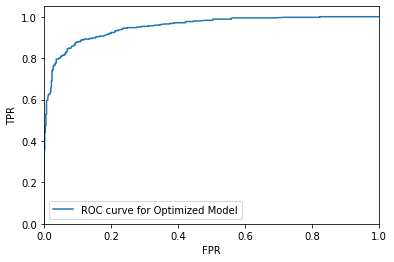

In [34]:
#fitting the classifier with best parameters obtained
r3=xgb.XGBClassifier(n_estimators=400  ,learning_rate= 0.2 ,max_depth= 2,colsample_bytree=0.5,colsample_bylevel=0.5).fit(x_train,y_train)

# obtain the estimator
best_clf = grid_fit.best_estimator_

#predictions using the unoptimized model and optimized model
predictions = (clf.fit(x_train, y_train)).predict(x_train)
best_predictions = best_clf.predict(x_train)
# score before optimization 
print ("Unoptimized model\n------")
print ("AUPRC on train data: {:.4f}".format(average_precision_score(y_train, predictions)))
print ("AUROC on train data: {:.4f}".format(roc_auc_score(y_train, predictions)))
print ("F-score on train data: {:.4f}".format(fbeta_score(y_train, predictions, beta = 5)))

#score after optimization
print ("\nOptimized Model\n------")
print ("Final AUPRC on the train data: {:.4f}".format(average_precision_score(y_train, best_predictions)))
print ("Final AUROC the train data: {:.4f}".format(roc_auc_score(y_train, best_predictions)))
print ("Final F-score on the train data: {:.4f}".format(fbeta_score(y_train, best_predictions, beta = 5)))
print(confusion_matrix(y_train,best_predictions))

probas_ = best_clf.predict_proba(x_train)
fpr, tpr, thresholds = roc_curve(y_train, probas_[:, 1])
area = auc(fpr, tpr)
print("Area Under ROC Curve for train data: ",area)
#plot roc curve
plt.plot(fpr, tpr, label='ROC curve for Optimized Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.show()

## ENSEMBLE: Voting Classifier( Soft Voting)

In [41]:
predictions=clf.predict(test)
submission=pd.DataFrame({'PassengerId':passenger_id,'Survived':predictions}).set_index('PassengerId')
submission.to_csv('Titanic_Submission_HV.csv')

In [35]:
clf=VotingClassifier(estimators=[("tree",r1),("rf",r2),('xgb',r3)],voting="soft").fit(x_train,y_train)
confusion_matrix(y_train,clf.predict(x_train))

array([[522,  27],
       [ 63, 279]], dtype=int64)

In [36]:
def roc_evaluation(r,x_train,y_train):
    plt.figure()
    fpr,tpr,_=roc_curve(y_train,r.predict_proba(x_train)[:,1])
    plt.plot(fpr,tpr,label="train_roc_curve")
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC_CURVE")
    print("roc_auc score of train set is {}".format(roc_auc_score(y_train,r.predict_proba(x_train)[:,1])))

roc_auc score of train set is 0.959264052663535


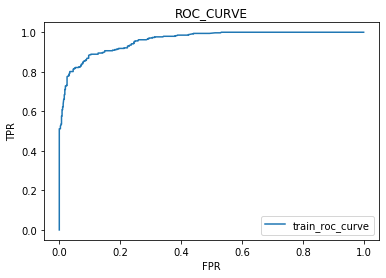

In [37]:
roc_evaluation(clf,x_train,y_train)

In [38]:
predictions=clf.predict(test)
submission=pd.DataFrame({'PassengerId':passenger_id,'Survived':predictions}).set_index('PassengerId')
submission.to_csv('Titanic_Submission.csv')